# Predicting Football Match Outcomes

### Introduction

This Python project aims to predict the outcome of football matches by predicting the expected goals a team will produce based on data known prior to the game related to team and opponent strength. 

The data is sourced from: https://beatthebookie.blog/download-excel-files/.

### Data Loading

In [88]:
import _sqlite3
import pandas as pd

# Loads in the data from the SQLite3 database
conn = _sqlite3.connect("data/historic_matches.db")
query = "SELECT DISTINCT * FROM match_data"
df = pd.read_sql_query(query, conn)


### Data Pre-processing

In [89]:
print(df.dtypes)

                         object
division_id              object
division                 object
season_id                object
season                   object
match_date               object
match_teams              object
home_team_id             object
home_team                object
away_team_id             object
away_team                object
home_num_players         object
home_market_value        object
home_avg_market_value    object
away_num_players         object
away_market_value        object
away_avg_market_value    object
home_goals               object
away_goals               object
home_shots               object
away_shots               object
home_shots_on_target     object
away_shots_on_target     object
home_corners             object
away_corners             object
home_yellow              object
away_yellow              object
home_red                 object
away_red                 object
home_xgoals              object
away_xgoals              object
home_dee

In [90]:
from sklearn.preprocessing import StandardScaler
# Transforms the datatypes of the columns in the dataframe. Also scales the numeric columns
df["match_date"] = pd.to_datetime(df["match_date"])

# Calculating the match outcome
def calculate_actual_match_outcome(row):
    if row["home_goals"] > row["away_goals"]:
        return "home win"
    elif row["home_goals"] < row["away_goals"]:
        return "away win"
    else:
        return "draw"   
df["actual_match_outcome"] = df.apply(calculate_actual_match_outcome, axis=1)

numeric_cols = ["home_num_players", "home_market_value", "home_avg_market_value", "away_num_players", "away_market_value", "away_avg_market_value",
                "home_goals", "away_goals", "home_shots", "away_shots", "home_shots_on_target", "away_shots_on_target", "home_corners", "away_corners",
                "home_red", "away_red", "home_yellow", "away_yellow", "home_deep", "away_deep", "home_ppda", "away_ppda"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols]) #Scaling the numeric columns

df["season"] = pd.to_numeric(df["season"].str[:4]) #converting season column to start year.
df["home_xgoals"] = pd.to_numeric(df["home_xgoals"])
df["away_xgoals"] = pd.to_numeric(df["away_xgoals"])

In [91]:
# Investigating nulls
null_counts = df.isnull().sum()
print(null_counts)


                             0
division_id                  0
division                     0
season_id                    0
season                       0
match_date                   0
match_teams                  0
home_team_id                 0
home_team                    0
away_team_id                 0
away_team                    0
home_num_players            64
home_market_value           64
home_avg_market_value       64
away_num_players            65
away_market_value           65
away_avg_market_value       65
home_goals                   3
away_goals                   3
home_shots                5218
away_shots                4838
home_shots_on_target      4838
away_shots_on_target      4838
home_corners              4838
away_corners              4838
home_yellow               4839
away_yellow               4837
home_red                  4837
away_red                  4837
home_xgoals               1244
away_xgoals               1244
home_deep                24225
away_dee

In [92]:
# Lots of the matches in the dataset are missing ppda/deep data, I want to use this is in the model so I will have to remove the matches that do not have this.
df = df.dropna(subset=["home_ppda"])
null_counts = df.isnull().sum()
print(null_counts)

                           0
division_id                0
division                   0
season_id                  0
season                     0
match_date                 0
match_teams                0
home_team_id               0
home_team                  0
away_team_id               0
away_team                  0
home_num_players           0
home_market_value          0
home_avg_market_value      0
away_num_players           0
away_market_value          0
away_avg_market_value      0
home_goals                 2
away_goals                 2
home_shots               383
away_shots                 3
home_shots_on_target       3
away_shots_on_target       3
home_corners               3
away_corners               3
home_yellow                4
away_yellow                3
home_red                   3
away_red                   3
home_xgoals                0
away_xgoals                0
home_deep                  0
away_deep                  0
home_ppda                  0
away_ppda     

As you can see from above, we still have some missing values despite removing rows with missing ppda stats. Let's investigate this.

In [93]:
# Printing the season and division of rows with null for home_shots
missing_shots = df[df["home_shots"].isnull()]
print(missing_shots[["season", "division"]])

       season        division
7225     2018      Bundesliga
12116    2018         La Liga
25607    2016         Ligue 1
37078    2020  Premier League
37079    2020  Premier League
...       ...             ...
37453    2020  Premier League
37454    2020  Premier League
37455    2020  Premier League
37456    2020  Premier League
37457    2020  Premier League

[383 rows x 2 columns]


It appears that there are 3 random games from different seasons in 2018 and 2016, but there appears to be lots in the 2020 Premier League Seasons. I will now check to see if that is all of that season which means we can remove.

In [94]:
# Investigating nulls specifically in Premier League 2020 season
prem_2020 = df[(df["division"] == "Premier League") & (df["season"] == 2020)]
print(prem_2020.count())

                         380
division_id              380
division                 380
season_id                380
season                   380
match_date               380
match_teams              380
home_team_id             380
home_team                380
away_team_id             380
away_team                380
home_num_players         380
home_market_value        380
home_avg_market_value    380
away_num_players         380
away_market_value        380
away_avg_market_value    380
home_goals               380
away_goals               380
home_shots                 0
away_shots               380
home_shots_on_target     380
away_shots_on_target     380
home_corners             380
away_corners             380
home_yellow              380
away_yellow              380
home_red                 380
away_red                 380
home_xgoals              380
away_xgoals              380
home_deep                380
away_deep                380
home_ppda                380
away_ppda     

As you can see from above, the entire season is missing home shots, this presents an issue as the 2020 season is bang in the middle. Rather than removing that season from the dataset (as it would mess up future rolling avg calculations) I plan on estimating shots based on shots on target.

In [95]:
# Filtering data set to all Premier League seasons bar 2020 and working out the ratio of shots on target to shots.
prem_games = df[(df["division"] == "Premier League") & (df["season"] != 2020)]
shots = prem_games["home_shots"].sum() + prem_games["away_shots"].sum()
shots_on_target = prem_games["home_shots_on_target"].sum() + prem_games["away_shots_on_target"].sum()
shots_to_sot_ratio = (shots_on_target / shots)
print(shots_to_sot_ratio)

0.22872732184962788


In [96]:
# Now we have ratio, time to set shots for Prem 2020 season as an estimated value.
df.loc[(df["season"] == 2020) & (df["division"] == "Premier League"), "home_shots"] = (df["home_shots_on_target"] / shots_to_sot_ratio)

Now that season has been handled. For the remaining missig values I am just going to remove them from the dataset, as there are a few individual cases of missing goals (not replaeable by an estimate) and shots which will not have a large impact on the moving averages down the line as they are isolated.

In [97]:
df = df.dropna(subset=["home_shots"])
df = df.dropna(subset=["home_goals"])

print(df.isnull().sum())

                         0
division_id              0
division                 0
season_id                0
season                   0
match_date               0
match_teams              0
home_team_id             0
home_team                0
away_team_id             0
away_team                0
home_num_players         0
home_market_value        0
home_avg_market_value    0
away_num_players         0
away_market_value        0
away_avg_market_value    0
home_goals               0
away_goals               0
home_shots               0
away_shots               0
home_shots_on_target     0
away_shots_on_target     0
home_corners             0
away_corners             0
home_yellow              1
away_yellow              0
home_red                 0
away_red                 0
home_xgoals              0
away_xgoals              0
home_deep                0
away_deep                0
home_ppda                0
away_ppda                0
bet365_home_odds         0
bet365_draw_odds         0
b

So, we have removed nulls out of the features we plan to use. There are missing odds in the bet365 odds but for now we can leave these as they will not be used in training the model.

The last part of this stage of the project will be to unpivot the data set so that we don't have a home and away team for each match, but rather two rows of data for every match and we have a team and opponent. This is because I want to capture the home effect as a feature and not to build two separate models to capture home and away performance.

In [98]:
# Separates out the home vs away and allows every team to have an individual row of data. Allows us to feature engineer home effect easier.
home_df = df[["division", "season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals",  "home_deep", "home_ppda",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals", "away_deep", "away_ppda",
              "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds", "actual_match_outcome"]].copy()
home_df["home?"] = 1
home_df = home_df.rename(columns={"home_team":"team", "home_avg_market_value":"avg_market_value", "home_goals":"goals",
             "home_shots":"shots", "home_xgoals":"xG",  "home_deep":"deep", "home_ppda":"ppda",
             "away_team":"opponent_team", "away_avg_market_value":"opponent_avg_market_value", "away_goals":"opponent_goals", 
             "away_shots": "opponent_shots", "away_xgoals": "opponent_xG", "away_deep":"opponent_deep", "away_ppda":"opponent_ppda"})

away_df = df[["division", "season", "match_date",
                "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_xgoals",  "away_deep", "away_ppda",
                "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_xgoals", "home_deep", "home_ppda",
                 "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds", "actual_match_outcome"]].copy()
away_df["home?"] = 0
away_df = away_df.rename(columns={"away_team":"team", "away_avg_market_value":"avg_market_value", "away_goals":"goals",
             "away_shots":"shots", "away_xgoals":"xG", "away_deep":"deep", "away_ppda":"ppda",
             "home_team":"opponent_team", "home_avg_market_value":"opponent_avg_market_value", "home_goals":"opponent_goals", 
             "home_shots": "opponent_shots", "home_xgoals": "opponent_xG", "home_deep":"opponent_deep", "home_ppda":"opponent_ppda"})

df = pd.concat([away_df, home_df])
df.sort_values(["match_date", "division"], inplace=True)

# Create a unique identifier for each game, so even though matches are now duplicated, they have the same id.
df["match_id"] = df.apply(
    lambda row: "-".join(sorted([row["division"], str(row["season"]), str(row['match_date']), row['team'], row['opponent_team']])),
    axis=1
) # This applies a function to each row that creates a list out of the above columns, sorts and sorts them in alphabetical order.
  # It then joins the contents of the strings to create a unique ID like: 2014-2014-08-08-Ligue 1-Paris SG-Reims

df["match_id"] = df["match_id"].apply(hash) # This then hashes the string ID into a numeric value.

### Exploratory Data Analysis

We are going to build a model for xG - let's analyse the distribution of this variable.

count    36524.000000
mean         1.375438
std          0.868935
min          0.000000
25%          0.720000
50%          1.211050
75%          1.860000
max          6.880000
Name: xG, dtype: float64


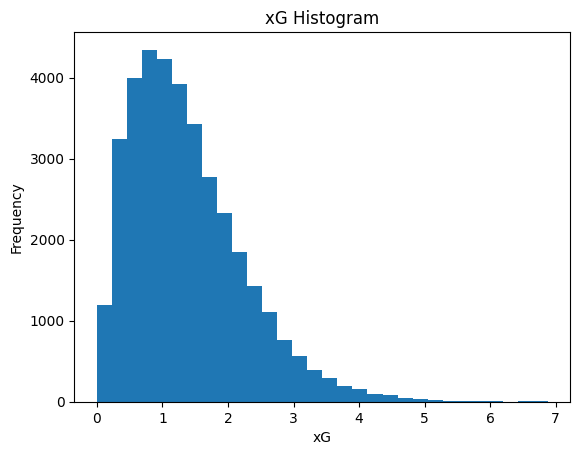

In [99]:
import matplotlib.pyplot as plt
print(df["xG"].describe())

plt.hist(df["xG"], bins=30)
plt.title("xG Histogram")
plt.xlabel("xG")
plt.ylabel("Frequency")
plt.show()


This suggests to us that despite standardising the data, a log transformation on the target variable may help reduce skewness which can help with model performance down the line.

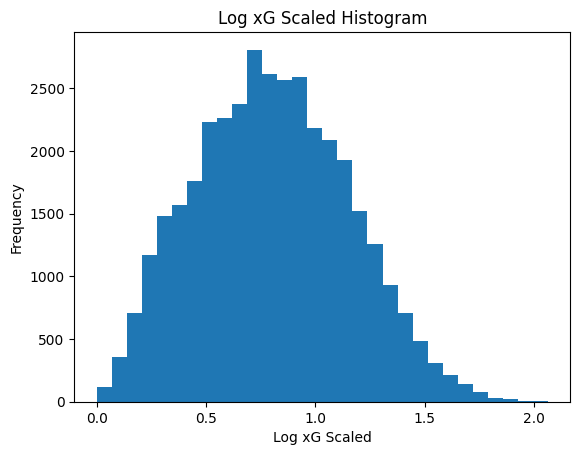

In [100]:
import numpy as np

df["xG_log"] = np.log1p(df["xG"]) #log1p to deal with 0s.

plt.hist(df["xG_log"], bins=30)
plt.title("Log xG Scaled Histogram")
plt.xlabel("Log xG Scaled")
plt.ylabel("Frequency")
plt.show()

As you can see, after performing log transformation, the target variable has now had skewness reduced and is more normally distributed.

Now let's produce a correlation matrix to see the relationships between the variables.

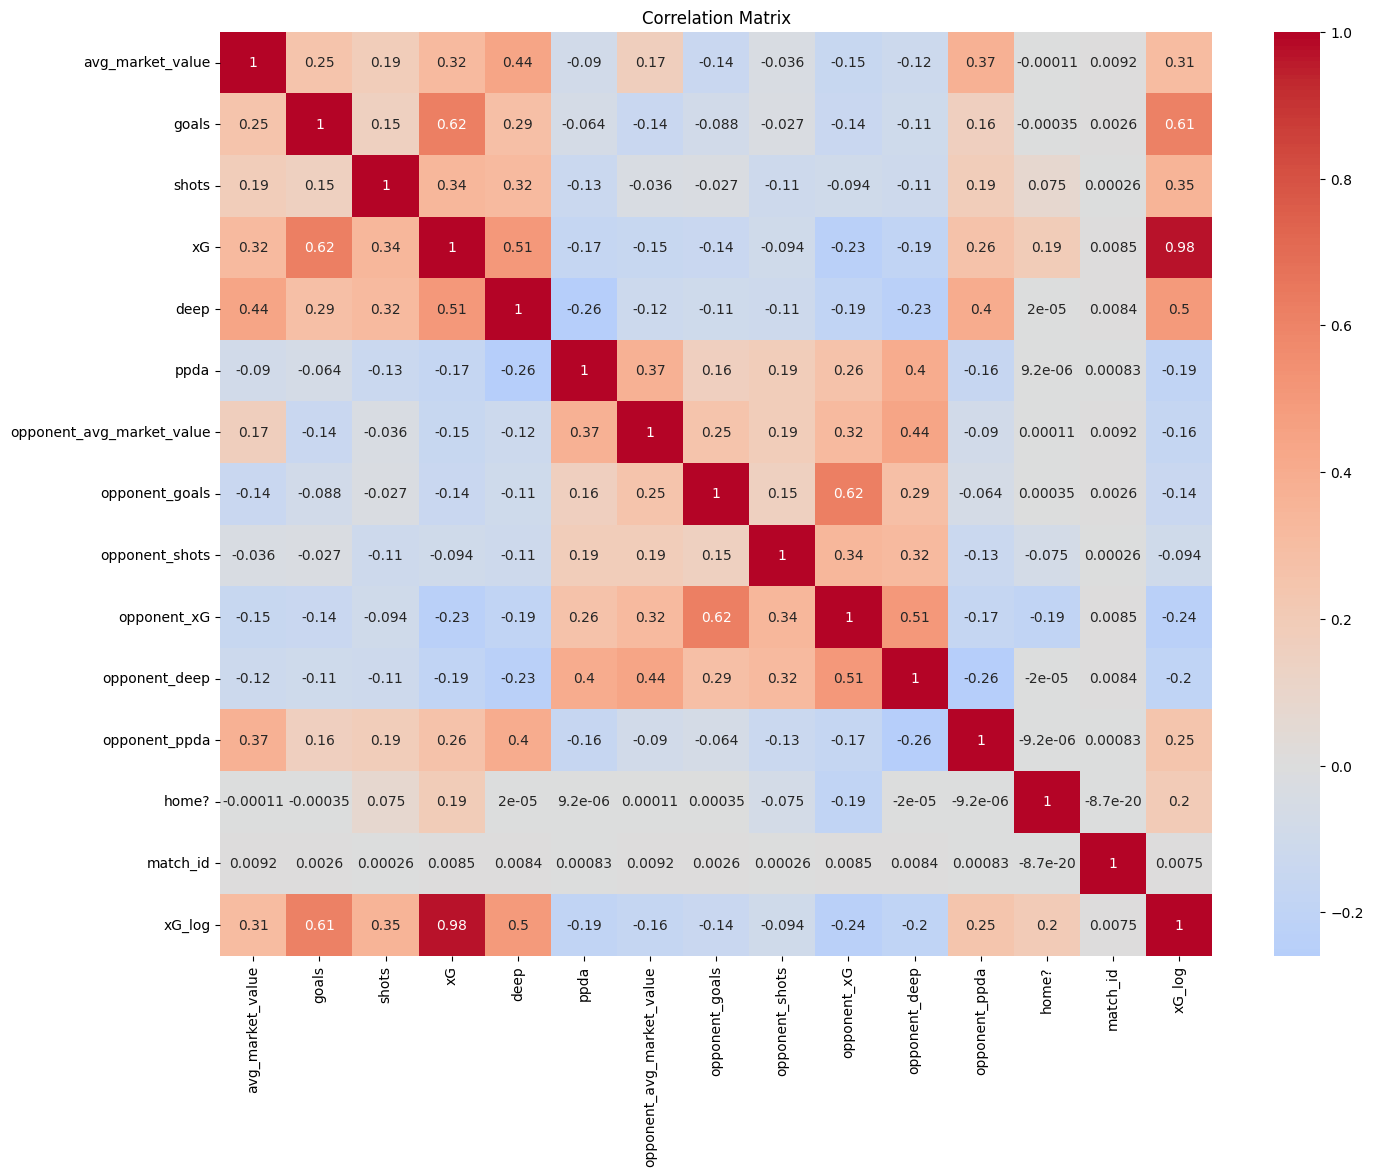

In [102]:
import seaborn as sns

correlation_matrix = df.drop(columns=["division", "season", "team", "opponent_team", "match_date", "bet365_home_odds",
                                       "bet365_draw_odds", "bet365_away_odds",  "actual_match_outcome"]).corr()

plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows nothing that requires action, the only highly correlated (>0.8) variables are xG_log and xG which is obvious as xG_log is a transformed version of xG.

### Feature Engineering

I plan to use an exponential moving average (EMA) feature for the team features here. I also want to ensure that games from previous seasons have a penalty applied when included in the EMA.

In [103]:
# Creating a function that can be used for different features
def penalized_ema(group_df, column_name, span=35):
    # Creates an exponential moving average that applies a penalty for games within span that are in previous seaoson
    ema_values = pd.Series(index=group_df.index, dtype=float)
    for season in group_df['season'].unique():
        season_data = group_df[group_df['season'] == season]
        season_ema = season_data[column_name].astype(float).ewm(span=span, adjust=False, min_periods=1).mean()
        if not ema_values.dropna().empty: # if ema_values series already has data then use last value from prev season
            # Get the last EMA value from the previous season
            last_season_ema_value = ema_values.ffill().iloc[-1]
            # Combine the last EMA value of the previous season with the first value of the new season
            # Here we give 65% weight to the first value of the new season and 35% weight to the previous season's last EMA value
            season_ema.iloc[0] = (season_ema.iloc[0] * 0.65) + (last_season_ema_value * 0.35)
        ema_values.update(season_ema)
    return ema_values

Now let's apply this function to some features.

In [104]:
# Compute EMAs for team stats
df.sort_values(by=["team", "match_date"], inplace=True)
stat_columns = ['goals', 'xG', 'shots', 'deep', 'ppda']

for col in stat_columns:
    df[f"rolling_{col}"] = df.groupby("team", group_keys=False).apply(lambda x: penalized_ema(x, col), include_groups=False)
    df[f"rolling_{col}_conceded"] = df.groupby("team", group_keys=False).apply(lambda x: penalized_ema(x, f'opponent_{col}'), include_groups=False)

df.reset_index(drop=True, inplace=True)

# Compute EMAs for opponent stats
df.sort_values(by=["opponent_team", "match_date"], inplace=True)

for col in stat_columns:
    df[f"opponent_rolling_{col}"] = df.groupby("opponent_team", group_keys=False).apply(lambda x: penalized_ema(x, f'opponent_{col}'), include_groups=False)
    df[f"opponent_rolling_{col}_conceded"] = df.groupby("opponent_team", group_keys=False).apply(lambda x: penalized_ema(x, col), include_groups=False)

df.reset_index(drop=True, inplace=True)


Let's also create a feature that calculates the number of days rest between games.

In [105]:
df.sort_values(by=["match_date", "team"], inplace=True)
df["days_rest"] = df.groupby(["season", "team"], observed=True)["match_date"].diff().dt.days
df["days_rest"] = df["days_rest"].fillna(0)

### Model Selection

We are now going to choose the best model for the problem. We are going to test a linear regression model, as well as an XGBoost model and compare the evaluation metrics such as MSE and R-squared to see which model performs the best.

Let's start with a linear regression model.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Begin with just predicting xG and not xGC
X = df[["home?", "rolling_shots", "rolling_goals", "rolling_xG", "rolling_deep",
            "opponent_rolling_shots_conceded", "opponent_rolling_xG_conceded","opponent_rolling_goals_conceded",
            "opponent_rolling_deep_conceded", "avg_market_value", "opponent_avg_market_value"]]
y_log = df["xG_log"]

X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train a linear regression model
linear_model = LinearRegression().fit(X_train, y_log_train)

# Predicting values on the trained model with the train and test datasets.
y_log_train_pred = linear_model.predict(X_train)
y_log_test_pred = linear_model.predict(X_test)

train_mse = mean_squared_error(y_log_train, y_log_train_pred)
train_r2 = r2_score(y_log_train, y_log_train_pred)
print(f"Training MSE: {train_mse} | Training R2: {train_r2}")

test_mse = mean_squared_error(y_log_test, y_log_test_pred)
test_r2 = r2_score(y_log_test, y_log_test_pred)
print(f"Test MSE: {test_mse} | Test R2: {test_r2}")


Training MSE: 0.08876668977841712 | Training R2: 0.2750884592397854
Test MSE: 0.08872306839468382 | Test R2: 0.26026754991702017


The above MSE and R2 scores show that whilst the model does not perform greatly in terms of predictive power (only attributing around 27% of the variance to the model's features) it appears to not show any signs of overfittng.

Next, I will apply some k-fold cross validation to further confirm this.

In [107]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the scoring functions for the KFold CV as MSE and R2
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

# Perform k-fold cross-validation for MSE
mse_scores = cross_val_score(linear_model, X, y_log, scoring=mse_scorer, cv=kf)
print(f'MSE scores for each fold: {mse_scores} | Average MSE: {np.mean(mse_scores)}')

# Perform k-fold cross-validation for R²
r2_scores = cross_val_score(linear_model, X, y_log, scoring=r2_scorer, cv=kf)
print(f'R² scores for each fold: {r2_scores} | Average R²: {np.mean(r2_scores)}')

MSE scores for each fold: [0.08872307 0.0897257  0.08845991 0.0882513  0.08898214] | Average MSE: 0.08882842171212953
R² scores for each fold: [0.26026755 0.25902239 0.29030447 0.27213903 0.27520801] | Average R²: 0.27138829144323473


The above confirms that the model is not overfitting at all as there are negligible differences between the MSEs for each K fold breakdown.

Let's now try an XGBoost model and see whether we can increase model performance.

In [108]:
import xgboost as xgb

# Define XGBoost model and use MSE as loss function
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Train model
xgb_model.fit(X_train, y_log_train)

# Predicting values on the trained model with the train and test datasets.
y_log_train_pred_xgb = xgb_model.predict(X_train)
y_log_test_pred_xgb = xgb_model.predict(X_test)

# Compute MSE and R² for the training set
train_mse_xgb = mean_squared_error(y_log_train, y_log_train_pred_xgb)
train_r2_xgb = r2_score(y_log_train, y_log_train_pred_xgb)
print(f"Training MSE: {train_mse_xgb} | Training R²: {train_r2_xgb}")

# Compute MSE and R² for the test set
test_mse_xgb = mean_squared_error(y_log_test, y_log_test_pred_xgb)
test_r2_xgb = r2_score(y_log_test, y_log_test_pred_xgb)
print(f"Test MSE: {test_mse_xgb} | Test R²: {test_r2_xgb}")

# Perform k-fold cross-validation for MSE
mse_scores_xgb = cross_val_score(xgb_model, X, y_log, scoring=mse_scorer, cv=kf)
print(f'MSE scores for each fold: {mse_scores_xgb} | Average MSE: {np.mean(mse_scores_xgb)}')

# Perform k-fold cross-validation for R²
r2_scores_xgb = cross_val_score(xgb_model, X, y_log, scoring=r2_scorer, cv=kf)
print(f'R² scores for each fold: {r2_scores_xgb} | Average R²: {np.mean(r2_scores_xgb)}')

Training MSE: 0.05397789061035799 | Training R²: 0.5591905483124722
Test MSE: 0.08801398293148929 | Test R²: 0.26617958087467064
MSE scores for each fold: [0.08866526 0.09104015 0.08929133 0.08904549 0.09025314] | Average MSE: 0.0896590738122693
R² scores for each fold: [0.2607495  0.24816733 0.28363412 0.26558889 0.26485524] | Average R²: 0.26459901514342477


The above demonstrates an improvement on model performance on the training set, however as displayed by the MSE and R-squared reduction on test set and k-fold cross validation scores, the model is now displaying signs of overfitting the data. Let's address this next by using GridSearchCV

In [109]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'alpha': [0, 0.1, 1],
    'lambda': [1, 1.5, 2]
}

# Initalise GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring="neg_mean_squared_error",
                           cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_log_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation MSE: {-grid_search.best_score_}")
best_model = grid_search.best_estimator_

# Evaluate on training set
y_log_train_pred_xgb = best_model.predict(X_train)

train_mse_xgb = mean_squared_error(y_log_train, y_log_train_pred_xgb)
train_r2_xgb = r2_score(y_log_train, y_log_train_pred_xgb)
print(f"train MSE: {train_mse_xgb} | train R²: {train_r2_xgb}")

# Evaluate on test set
y_log_test_pred_xgb = best_model.predict(X_test)

test_mse_xgb = mean_squared_error(y_log_test, y_log_test_pred_xgb)
test_r2_xgb = r2_score(y_log_test, y_log_test_pred_xgb)
print(f"Test MSE: {test_mse_xgb} | Test R²: {test_r2_xgb}")


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'alpha': 1, 'colsample_bytree': 0.8, 'lambda': 2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation MSE: 0.08593616942099427
train MSE: 0.07771968338276036 | train R²: 0.3653036339528858
Test MSE: 0.08470506637714904 | Test R²: 0.29376781687856546


Although the perfomance on the training set has decreased, the model now performs better on the test set and cross-validation set. This indicates that the model no longer overfits and generalises better to unseen data. Regularization has successfuly reduced overfitting and made the model more robust and reliable. This is the model that we are going to choose, as it also displays a significant improvement over the linear regression model.

Let's now evaluate the model.

### Model Evalutation

In this next section I plan to evaluate the model. Within the dataset that we have, we have the Bet365 historic match odds. We are going to compare how our model performs in terms of predicting match outcomes based on this predicted xG.

In [110]:
# Adding the model's predicted xG values back into the main dataframe.
pred_xG_log = xgb_model.predict(X)
pred_xG = np.expm1(pred_xG_log)
pred_xg_series = pd.Series(pred_xG, index=df.index)

df["pred_xG"] = pred_xg_series

In [145]:
# Maybe counter-intuitively, but we are now re-merging the symmetric dataset into home/away so that we can generate match odds.
print(df.columns)


home_df = df[df["home?"] == 1].rename(columns={'team': 'home_team', 'pred_xG': 'home_pred_xG', "xG": "home_xG", "goals":"home_goals"})
away_df = df[df['home?'] == 0].rename(columns={'team': 'away_team', 'pred_xG': 'away_pred_xG', "xG": "away_xG", "goals":"away_goals"})

merged_df = pd.merge(home_df[['match_id', 'match_date', 'home_team', 'home_pred_xG', "home_xG", "home_goals", "bet365_home_odds", 
                              "bet365_draw_odds", "bet365_away_odds", "actual_match_outcome"]],
                     away_df[['match_id', 'away_team', 'away_pred_xG', "away_xG", "away_goals"]],
                     on='match_id')

eval_df = merged_df[["match_date", "home_team", "home_xG", "home_pred_xG", "home_goals", "away_team", "away_xG", "away_goals", "away_pred_xG",
                      "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds", "actual_match_outcome"]]



# There are a few null odds from before, remove these
eval_df.replace("", np.nan, inplace=True)

# Calculating implied probability from decimal odds
eval_df["bet365_home_%"] = (1 / eval_df["bet365_home_odds"].astype(float))
eval_df["bet365_draw_%"] = (1 / eval_df["bet365_draw_odds"].astype(float))
eval_df["bet365_away_%"] = (1 / eval_df["bet365_away_odds"].astype(float))

# Betting companies apply a margin to their odds, where the total implied probability is > 100%, we are calculating this
eval_df["bet365_total_%"] = (eval_df["bet365_away_%"] + eval_df["bet365_draw_%"] + eval_df["bet365_home_%"])
eval_df["bet365_margin"] = eval_df["bet365_total_%"] - 100

# We are then removing the proportional margin to each set of odds so that we have a fair comparison.
eval_df["bet365_home_fair_%"] = (eval_df["bet365_home_%"] - (eval_df["bet365_home_%"] / eval_df["bet365_total_%"]) * eval_df["bet365_margin"]) / 100
eval_df["bet365_draw_fair_%"] = (eval_df["bet365_draw_%"] - (eval_df["bet365_draw_%"] / eval_df["bet365_total_%"]) * eval_df["bet365_margin"]) / 100
eval_df["bet365_away_fair_%"] = (eval_df["bet365_away_%"] - (eval_df["bet365_away_%"] / eval_df["bet365_total_%"]) * eval_df["bet365_margin"]) / 100


Index(['division', 'season', 'match_date', 'team', 'avg_market_value', 'goals',
       'shots', 'xG', 'deep', 'ppda', 'opponent_team',
       'opponent_avg_market_value', 'opponent_goals', 'opponent_shots',
       'opponent_xG', 'opponent_deep', 'opponent_ppda', 'bet365_home_odds',
       'bet365_draw_odds', 'bet365_away_odds', 'actual_match_outcome', 'home?',
       'match_id', 'xG_log', 'rolling_goals', 'rolling_goals_conceded',
       'rolling_xG', 'rolling_xG_conceded', 'rolling_shots',
       'rolling_shots_conceded', 'rolling_deep', 'rolling_deep_conceded',
       'rolling_ppda', 'rolling_ppda_conceded', 'opponent_rolling_goals',
       'opponent_rolling_goals_conceded', 'opponent_rolling_xG',
       'opponent_rolling_xG_conceded', 'opponent_rolling_shots',
       'opponent_rolling_shots_conceded', 'opponent_rolling_deep',
       'opponent_rolling_deep_conceded', 'opponent_rolling_ppda',
       'opponent_rolling_ppda_conceded', 'days_rest', 'pred_xG'],
      dtype='object')


C:\Users\Owner\AppData\Local\Temp\ipykernel_15040\3129926630.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df.replace("", np.nan, inplace=True)


In [146]:
from scipy.stats import poisson

def calculate_match_outcome_prob(row):
    # Calculating implied probability using a Poisson model and our own predicted xG
    xG_home = row["home_pred_xG"]
    xG_away = row["away_pred_xG"]
    max_goals = 10

    # Poisson probabilities for each team scoring from 0 to max_goals
    prob_home = poisson.pmf(np.arange(max_goals+1), xG_home)
    prob_away = poisson.pmf(np.arange(max_goals+1), xG_away)

    # Calculate probability of both teams scoring same number of goals (draw)
    prob_draw = np.sum(prob_home * prob_away)

    # Calculate probability of home team scoring more goals than away team (home win)
    prob_home_win = sum(prob_home[i] * sum(prob_away[:i]) for i in range(1, max_goals+1))

    # Calculate probability of away team scoring more goals than home team (away win)
    prob_away_win = sum(prob_away[i] * sum(prob_home[:i]) for i in range(1, max_goals+1))

    return pd.Series([prob_home_win, prob_draw, prob_away_win])

# Adding the probabilities as columns to each row.
eval_df[["prob_home_win", "prob_draw", "prob_away_win"]] = eval_df.apply(calculate_match_outcome_prob, axis=1)

eval_df = eval_df[["match_date", "home_team", "home_xG", "home_pred_xG", "away_team", "away_xG", "away_pred_xG",
                   "prob_home_win", "bet365_home_fair_%", "prob_draw", "bet365_draw_fair_%", "prob_away_win",
                   "bet365_away_fair_%", "actual_match_outcome"]]

print(eval_df.loc[2000])

match_date              2015-09-12 00:00:00
home_team                           Watford
home_xG                                1.57
home_pred_xG                       1.208529
away_team                           Swansea
away_xG                                 0.5
away_pred_xG                       0.885815
prob_home_win                      0.435125
bet365_home_fair_%                 0.356021
prob_draw                          0.294762
bet365_draw_fair_%                 0.287958
prob_away_win                      0.270112
bet365_away_fair_%                 0.356021
actual_match_outcome               home win
Name: 2000, dtype: object


In [147]:
# Now, we are getting the predicted match outcomes from the highest implied probabilitiy

def get_predicted_outcome(row):
    probs = [row["prob_home_win"], row["prob_draw"], row["prob_away_win"]]
    outcomes = ["home win", "draw", "away win"]
    return outcomes[probs.index(max(probs))]

def get_bet365_predicted_outcome(row):
    probs = [row["bet365_home_fair_%"], row["bet365_draw_fair_%"], row["bet365_away_fair_%"]]
    outcomes = ["home win", "draw", "away win"]
    return outcomes[probs.index(max(probs))]

eval_df["predicted_match_outcome"] = eval_df.apply(get_predicted_outcome, axis=1)
eval_df["bet365_predicted_match_outcome"] = eval_df.apply(get_bet365_predicted_outcome, axis=1)

In [148]:
from sklearn.metrics import brier_score_loss

# Create binary indicator columns for the actual outcomes
eval_df["actual_home_win"] = (eval_df["actual_match_outcome"] == "home win").astype(int)
eval_df["actual_draw"] = (eval_df["actual_match_outcome"] == "draw").astype(int)
eval_df["actual_away_win"] = (eval_df["actual_match_outcome"] == "away win").astype(int)

# Calculate Brier scores for each type of prediction
eval_df["brier_home_win"] = brier_score_loss(eval_df["actual_home_win"], eval_df["prob_home_win"])
eval_df["brier_draw"] = brier_score_loss(eval_df["actual_draw"], eval_df["prob_draw"])
eval_df["brier_away_win"] = brier_score_loss(eval_df["actual_away_win"], eval_df["prob_away_win"])

eval_df.dropna(subset=["bet365_home_fair_%"], inplace=True)
eval_df.dropna(subset=["bet365_draw_fair_%"], inplace=True)
eval_df.dropna(subset=["bet365_away_fair_%"], inplace=True)
print(eval_df.isnull().sum())

# Calculate Brier scores for Bet365 probabilities
eval_df["brier_bet365_home_win"] = brier_score_loss(eval_df["actual_home_win"], eval_df["bet365_home_fair_%"])
eval_df["brier_bet365_draw"] = brier_score_loss(eval_df["actual_draw"], eval_df["bet365_draw_fair_%"])
eval_df["brier_bet365_away_win"] = brier_score_loss(eval_df["actual_away_win"], eval_df["bet365_away_fair_%"])

print(eval_df.loc[2000])

match_date                        0
home_team                         0
home_xG                           0
home_pred_xG                      0
away_team                         0
away_xG                           0
away_pred_xG                      0
prob_home_win                     0
bet365_home_fair_%                0
prob_draw                         0
bet365_draw_fair_%                0
prob_away_win                     0
bet365_away_fair_%                0
actual_match_outcome              0
predicted_match_outcome           0
bet365_predicted_match_outcome    0
actual_home_win                   0
actual_draw                       0
actual_away_win                   0
brier_home_win                    0
brier_draw                        0
brier_away_win                    0
dtype: int64
match_date                        2015-09-12 00:00:00
home_team                                     Watford
home_xG                                          1.57
home_pred_xG                     